In [1]:
import torch
import math
from torch.distributions import Normal, Uniform
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt  
import numpy as np  

from trickster import Trickster, Vanilla

torch.__version__

'0.4.1'

In [2]:
# train_size = 1000
# valid_size = 100


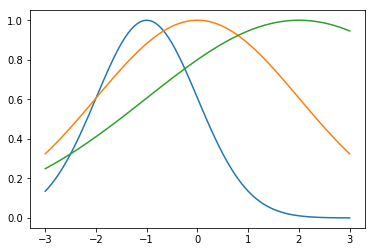

In [3]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x.copy() - mu, 2.) / (2 * np.power(sig, 2.)))

g = 0
for mu, sig in [(-1, 1), (0, 2), (2, 3)]:
    r = np.linspace(-3, 3, 100)
    g += gaussian(r, mu, sig)
    plt.plot(r, gaussian(r, mu, sig))
#plt.plot(r, g)



plt.show()

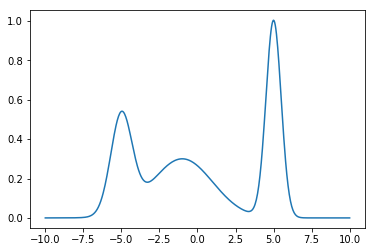

In [4]:

plt.plot(np.linspace(-10, 10, 500), 
             gaussian(np.linspace(-10, 10, 500), 5, 0.5) +
             0.3 * gaussian(np.linspace(-10, 10, 500), -1, 2) +
             0.5 * gaussian(np.linspace(-10, 10, 500), -5, 0.7))
plt.show()

200


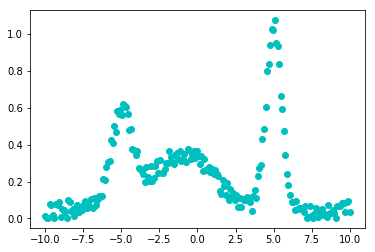

In [5]:
def n_gas(x_range, n_samples, means, stds, weights):
    x = np.linspace(-x_range, x_range, n_samples)
    g = sum(weight * gaussian(x, mean, std)
            for weight, mean, std in zip(weights, means, stds))
    print(len(g))
    g += 0.1 * np.random.random_sample(len(g))
    return x, g

x, y = n_gas(10, 200, [5, -1, -5], [0.5, 2, 0.7], [1, 0.3, 0.5])
plt.plot(x, y, 'co')
plt.show()
    
    
    
    

In [6]:
# x, g = n_gas(10, 200, np.random.randint(-5, 5, 3), np.random.random_sample(3), np.random.random_sample(3))
# plt.plot(x, g)
# plt.show()

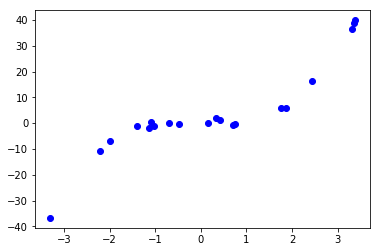

In [7]:
def data_set(fn, n_range_samples, ranges):
    x_values = []
    for min_x, max_x in ranges:
        uniform = Uniform(min_x, max_x)
        x_values += [uniform.sample().item() for _ in range(n_range_samples)]
    x_values = sorted(x_values)
    y_values = [fn(x) for x in x_values]
    return x_values, y_values

def tensor_dataset(x, y):
    return TensorDataset(torch.tensor(x).float()[:, None], torch.tensor(y).float()[:, None])

def data_loader(x_values, y_values, batch_size=None):
    batch_size =  batch_size or len(x_values)
    dataset = tensor_dataset(x_values, y_values)
    return DataLoader(dataset, shuffle=True, batch_size=batch_size)

def lobato(x):
    normal = Normal(torch.tensor([0.0]), torch.tensor([1.0]))
    y = (x ** 3) + normal.sample().item()
    return y 

#x_train, y_train = data_set(fn=lobato, n_range_samples=10, ranges=[(-4, -2), (2, 4)])
x_train, y_train = data_set(fn=lobato, n_range_samples=20, ranges=[(-4, 4)])
train_dataset = data_loader(x_train, y_train)

plt.plot(np.array(x_train), np.array(y_train), 'bo')
plt.show()


    

In [8]:
epochs = 500

# def normalise(t): return (t - t.mean()) / t.std()

def fit(model, dataset):
    
    optim = torch.optim.Adam(model.parameters(), lr=0.1)
    
    beta = 0.5
    alpha = beta
    for e in range(epochs):
        for a, b in dataset:

            optim.zero_grad()

            mean, std = model(a, b)
            
            loss_a = torch.nn.MSELoss()(mean, b) 
            
            loss_b = std.mean()

            alpha += 0.001 * (loss_b.item() - beta)
            
            loss = loss_a + alpha * loss_b
            
            loss.backward()
            optim.step()
        

In [9]:
x_range = np.arange(-7, 7, 0.2).tolist()

def plot(values, model):
    with torch.no_grad():
        
        plt.plot(np.array(x_train), np.array(y_train), 'bo')
        
        model.eval()
        mean, std = model(torch.tensor(values)[:, None])
        
        plt.plot(values, mean.numpy())
        print(std.mean())
        
        plt.plot(values, (mean + (3 * std)).numpy())
        plt.plot(values, (mean - (3 * std)).numpy())

        # plt.xlabel('time (s)')  
        # plt.ylabel('voltage (mV)')  
        # plt.title('voltage (mV) vs. time (sec)')   
        # plt.grid(True)  
        # plt.savefig("plot-voltage-vs.-time.png")  
        plt.show()  



In [10]:
input_size = 1
hidden_size = 10
n_samples = 10

tensor(0.4483)


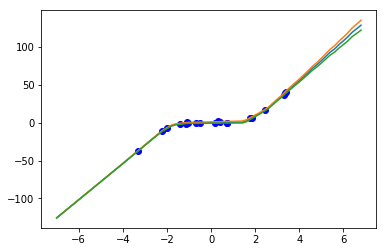

In [11]:
trick_model = Trickster(input_size, hidden_size, n_samples)
fit(trick_model, train_dataset)
plot(x_range, trick_model)

tensor(0.)


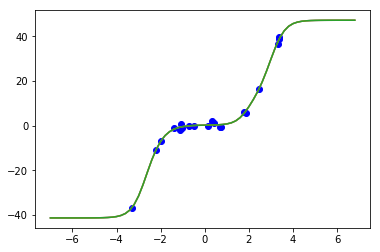

In [12]:
vanilla_model = Vanilla(input_size, hidden_size)
fit(vanilla_model, train_dataset)
plot(x_range, vanilla_model)

In [13]:
# validate
def validate(model, dataset):
    model.eval()
    with torch.no_grad():
        loss = torch.tensor([0.0])
        for a, b in dataset:
            mean, std = model(a, b)
            loss += torch.nn.MSELoss()(mean, b)
        return loss.mean()
        
print(f'Trickster -> {validate(trick_model, train_dataset)}')
print(f'Vanilla   -> {validate(vanilla_model, train_dataset)}')

Trickster -> 0.6538652181625366
Vanilla   -> 0.6322428584098816


matplotlib.figure.Figure

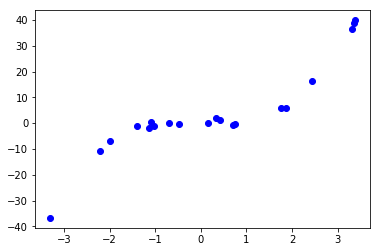

In [16]:
fig, ax = plt.subplots()
ax.plot(np.array(x_train), np.array(y_train), 'bo')
type(fig)